## Data Preparation

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, Normalizer, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

state = np.random.RandomState(12345)

In [24]:
# df = pd.read_csv(r'D:\StudySpace\Nam4_KyI\cap1_ai_feature\data\final_dataset_asian.csv')
df = pd.read_csv(r'D:\StudySpace\Nam4_KyI\cap1_ai_feature\data\balanced_dataset_asian.csv')

Peek into the data:

In [25]:
df.head()

,Weight,Height,BMI,Age,Gender,BMIcase,Exercise Recommendation Plan
0,92.085190,1.760250,29.719488,59,Female,Obese,6
1,61.089124,1.595499,23.997776,25,Female,Overweight,5
2,82.454037,1.816538,24.987499,50,Female,Overweight,5
3,101.713306,1.790696,31.720047,62,Female,Obese,6
4,99.609527,1.969726,25.673756,57,Male,Overweight,5


In [26]:
print(df.isna().sum())

Weight                          0
Height                          0
BMI                             0
Age                             0
Gender                          0
BMIcase                         0
Exercise Recommendation Plan    0
dtype: int64


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10689 entries, 0 to 10688
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Weight                        10689 non-null  float64
 1   Height                        10689 non-null  float64
 2   BMI                           10689 non-null  float64
 3   Age                           10689 non-null  int64  
 4   Gender                        10689 non-null  object 
 5   BMIcase                       10689 non-null  object 
 6   Exercise Recommendation Plan  10689 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 584.7+ KB


## Exploratory data analysis


In [28]:
df.describe()

,Weight,Height,BMI,Age,Exercise Recommendation Plan
count,10689.000000,10689.000000,10689.000000,10689.000000,10689.000000
mean,73.100122,1.792832,23.236664,41.339695,4.000000
std,21.161896,0.125787,8.197413,13.750747,2.000094
min,50.000000,1.390171,12.753801,18.000000,1.000000
25%,55.943683,1.732188,16.766271,29.000000,2.000000
50%,65.705827,1.805181,20.964623,41.000000,4.000000
75%,87.360575,1.891355,28.861746,53.000000,6.000000
max,160.000000,1.990000,78.853402,65.000000,7.000000


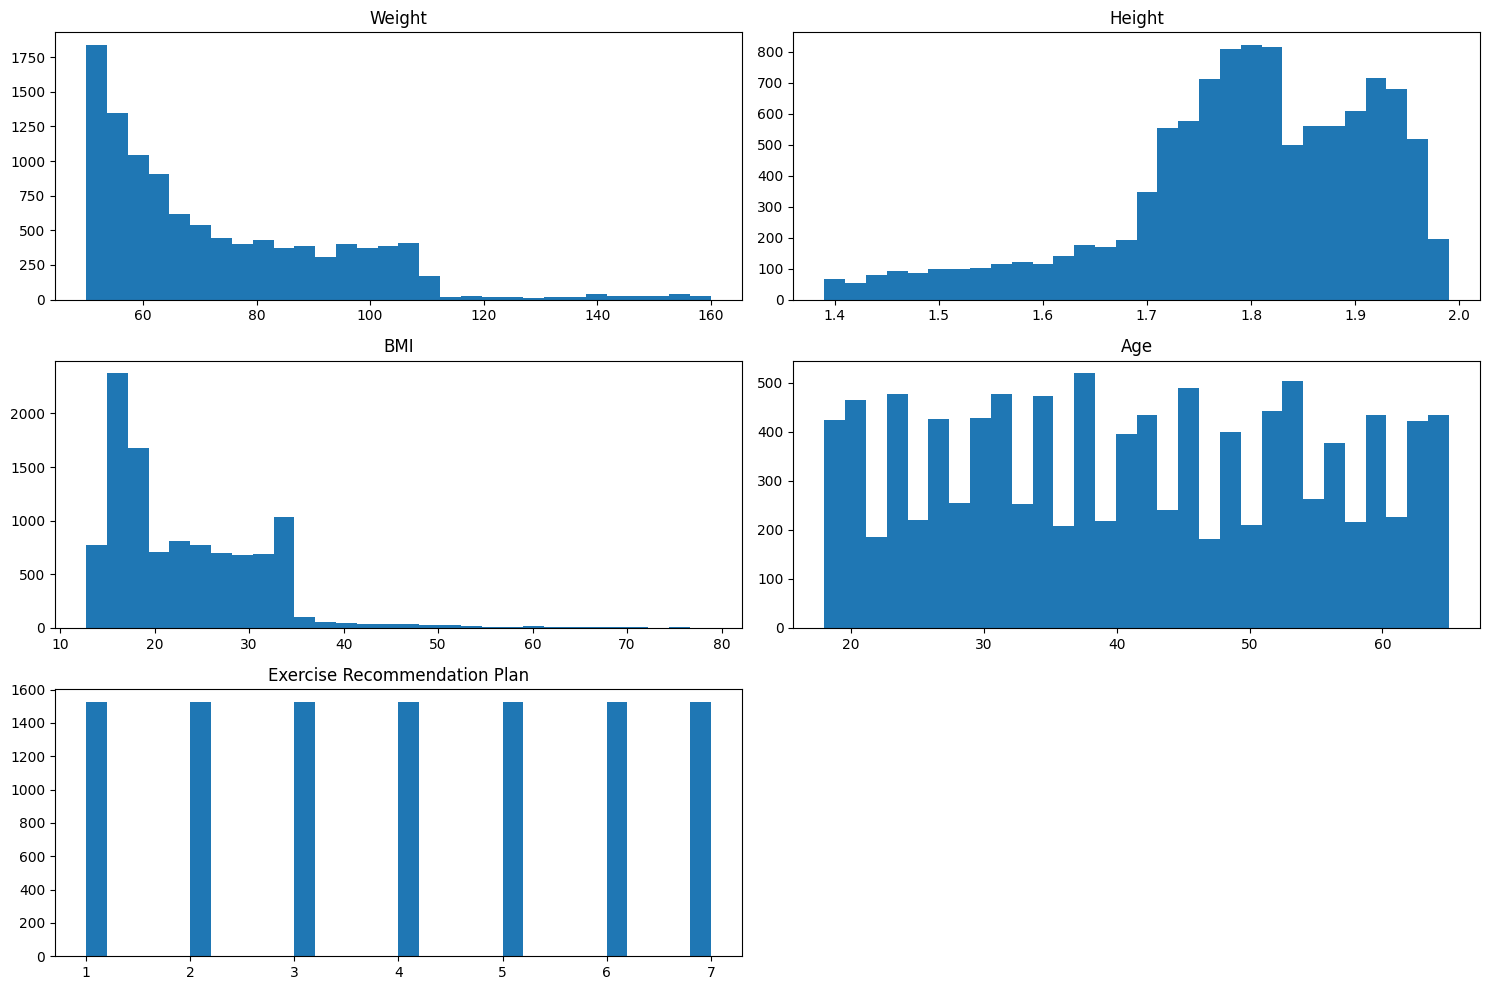

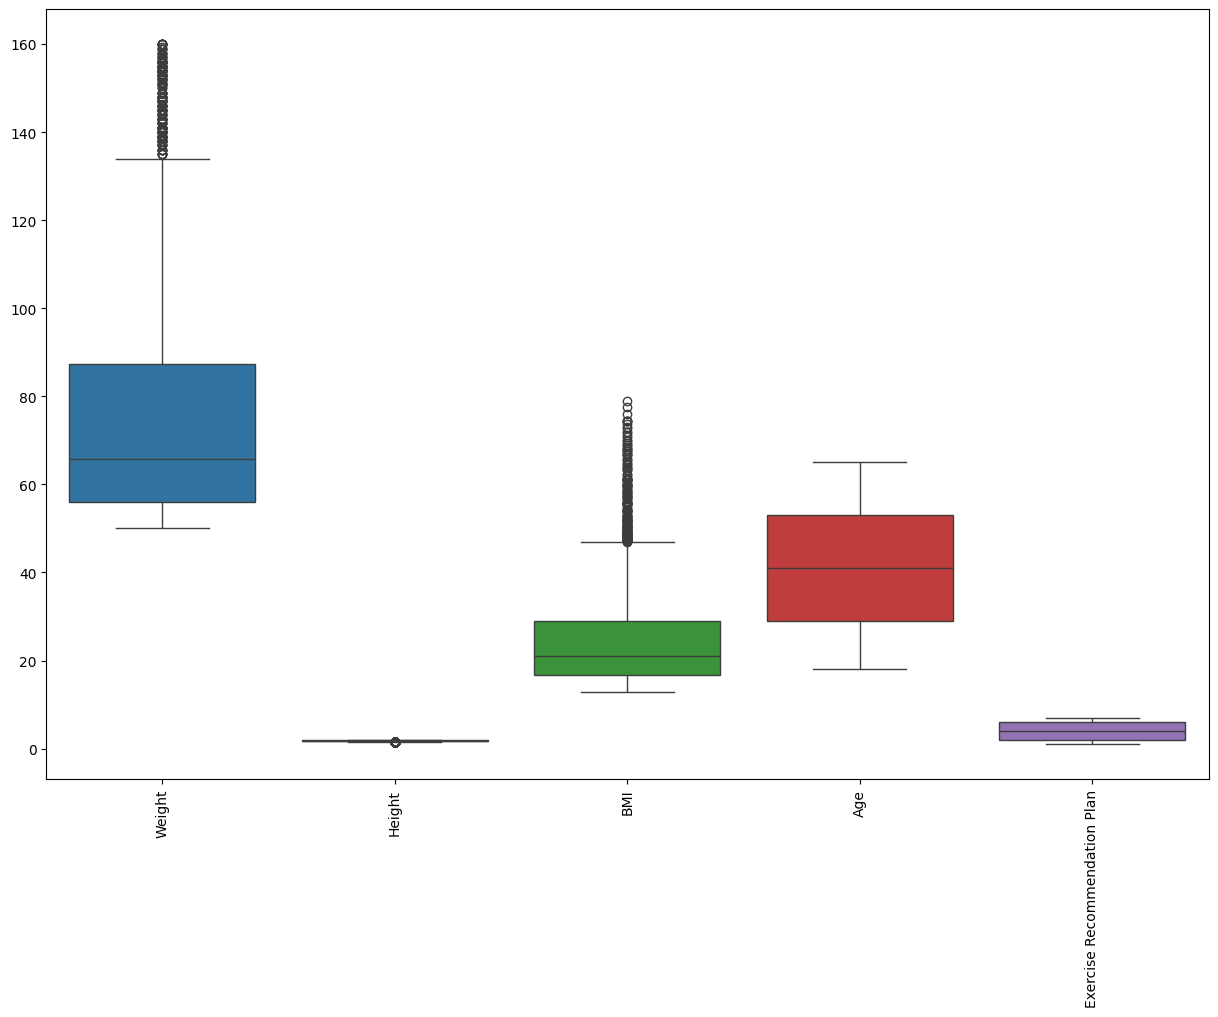

In [29]:
df.hist(bins=30, figsize=(15, 10), grid=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

Index(['Weight', 'Height', 'BMI', 'Age', 'Gender', 'BMIcase',
       'Exercise Recommendation Plan'],
      dtype='object')


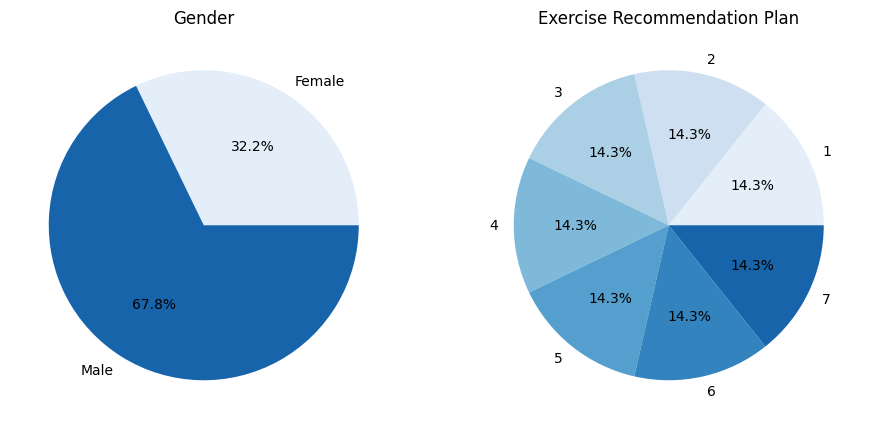

In [30]:
# Check the column names in the dataframe
print(df.columns)

_, axs = plt.subplots(1, 2, figsize=[11,11])
cols = [
    (axs[0], 'Gender'),
    (axs[1], 'Exercise Recommendation Plan'),
]   

cmap = plt.get_cmap('Blues')
for i, (ax, col) in enumerate(cols):
    ax.set(title=col)
    values = df[col].value_counts().sort_index()
    ind = values.index
    colors = list(cmap(np.linspace(0.1, 0.8, len(values))))
    ax.pie(
        values, 
        labels=ind, 
        autopct='%.1f%%', 
        colors=colors
    )
    


C:\Users\ACER\AppData\Local\Temp\ipykernel_13068\2862379173.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='BMIcase', data=df, palette=custom_colors)


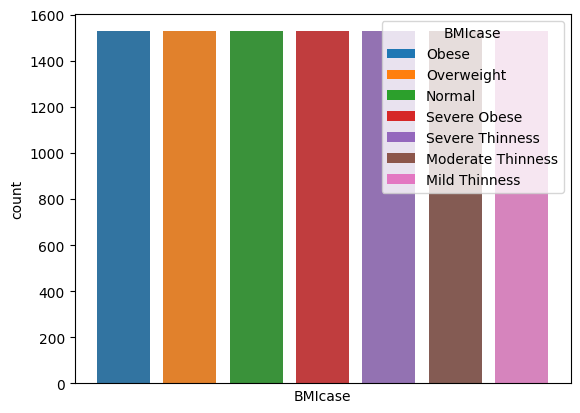

In [31]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# Map each category to a color in a dictionary
color_map = dict(zip(df['BMIcase'].unique(), custom_colors))

sns.countplot(x='BMIcase', data=df, palette=custom_colors)
plt.xticks([])  # Remove x-axis labels

# Manually add a legend using the color map
for category, color in color_map.items():
    plt.bar(0, 0, color=color, label=category, linewidth=0)
plt.legend(title="BMIcase")

plt.show()

In [32]:
# BMI range for each BMI case, ordered by min BMI
print(df.groupby('BMIcase')['BMI'].agg(['min', 'max', 'median', 'std']).sort_values('min'))

                         min        max     median       std
BMIcase                                                     
Severe Thinness    12.753801  15.992804  14.927763  0.759032
Mild Thinness      16.004176  16.995148  16.560909  0.254742
Moderate Thinness  17.001572  18.499102  17.723965  0.375005
Normal             18.503725  22.991690  20.964623  1.289132
Overweight         23.003162  27.494902  25.363503  1.285755
Obese              27.504044  32.488013  30.021502  1.416306
Severe Obese       32.504904  78.853402  34.125262  7.969053


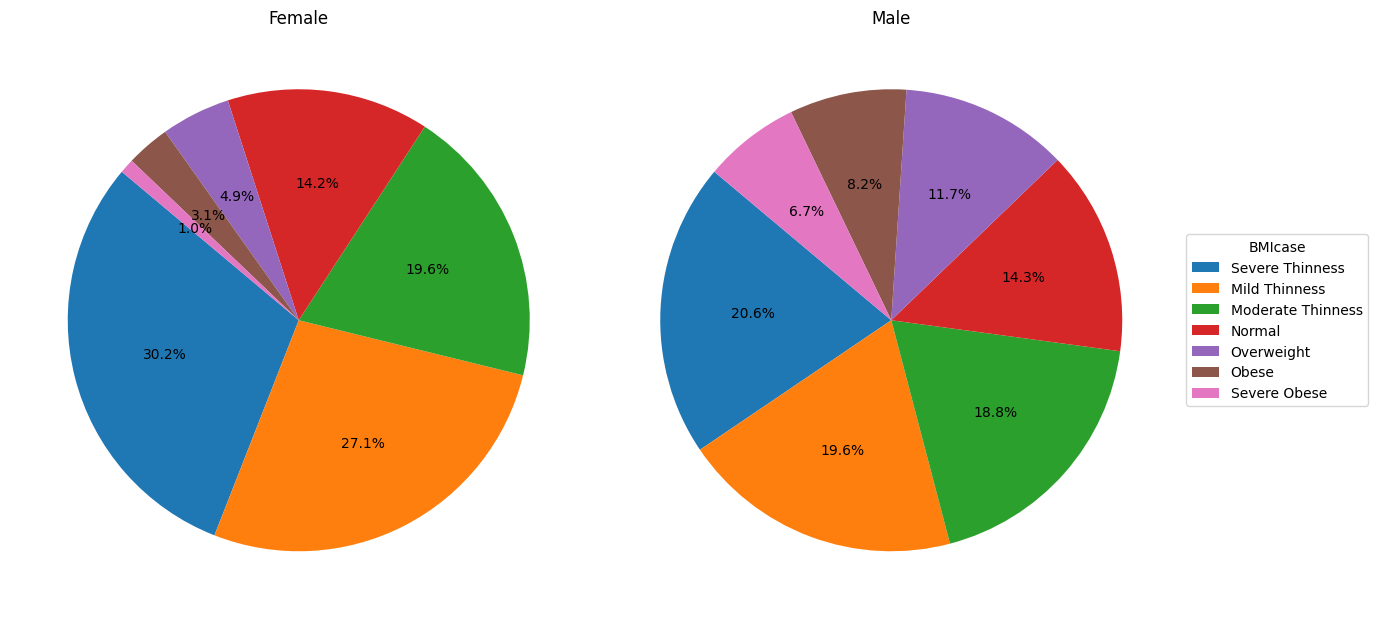

In [33]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Get unique genders in the data
genders = df['Gender'].unique()

# Create a figure with subplots for each gender
fig, axes = plt.subplots(1, len(genders), figsize=(12, 8), subplot_kw={'aspect': 'equal'})

# Loop through each gender and plot a pie chart in each subplot
for i, gender in enumerate(genders):
    # Filter data by gender and get BMIcase counts
    gender_data = df[df['Gender'] == gender]
    bmi_counts = gender_data['BMIcase'].value_counts()
    
    # Plot pie chart in the respective subplot
    wedges, texts, autotexts = axes[i].pie(
        bmi_counts, labels=None, autopct='%1.1f%%', startangle=140, colors=custom_colors
    )
    
    # Set title for each subplot
    axes[i].set_title(f'{gender}')

# Create a single legend for all pie charts outside the subplots
fig.legend(wedges, bmi_counts.index, title="BMIcase", loc="center right", bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.show()


# Model training

Let's start by clarifying that Exercise Recommendation Plan is a categorical system (suitable Workout Plans for each BMI level) so actually we are faced with multi-classification task, but our task will be solved with the use of classification models. Selected scoring metric will be f1-macro score.

I'll be trying following classification models:
- k-Nearest Neighbors
- Decision Trees
- Random Forest
- Gradient Boosting

In [34]:
cat_features = [
    'Gender', 
]

num_features = [
    'Weight', 
    'Height', 
    'Age', 
]

target = 'Exercise Recommendation Plan'

X_train, X_test, y_train, y_test = train_test_split(
    df[cat_features+num_features], 
    df[target], 
    test_size=0.2, 
    random_state=state
)

Train selected models in pipeline after OrdinalEncoder and normalization:

In [ ]:
# Pipeline stuff
# adding imputer in case future df updates will be with NaNs

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), # imputer is used to fill missing values
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())  # Or OneHotEncoder(handle_unknown='ignore')
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

### Model Evaluation with F1-Macro Score
In this step, I evaluate four different classifiers (K-Nearest Neighbors, Decision Tree, Random Forest, and Gradient Boosting) using 5-fold cross-validation. The F1-macro score is used as the evaluation metric, which balances precision and recall across all classes by treating each class equally, regardless of its frequency.

Because the dataset has been balanced (using SMOTE), the `F1-macro score` is more appropriate for evaluating the classifiers. Here's why:
- `Balances Precision and Recall`: The F1-macro score considers how well the model correctly identifies recommendations (precision) and how many of the correct recommendations it captures (recall) for each class.
- `Treats All Classes Equally`: Unlike metrics that depend on class frequency, F1-macro ensures that all 7 exercise recommendation plans are evaluated equally, making it ideal for balanced datasets.

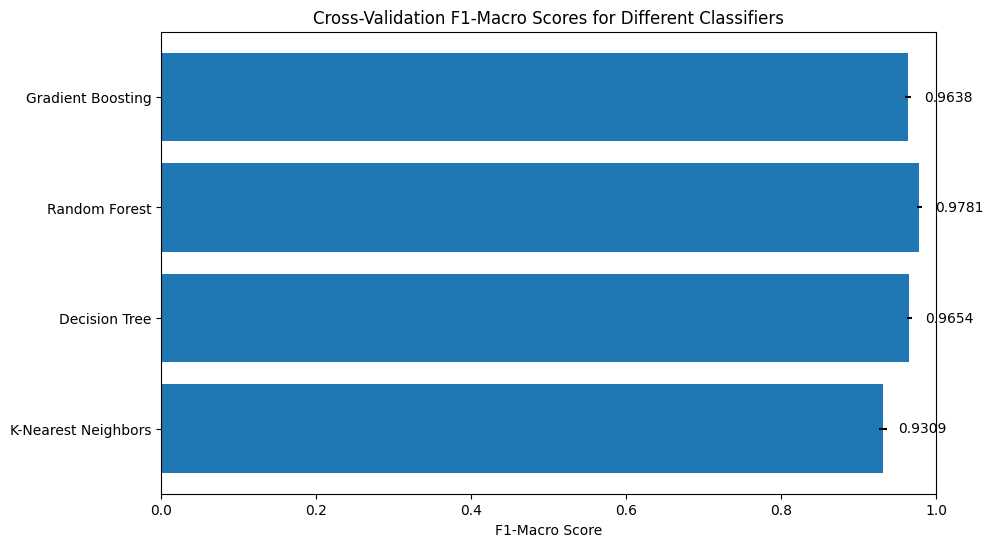

In [42]:
classifiers = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier() 
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', clf)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    
    results[name] = {"cv_scores": cv_scores}


# Calculate the mean and std of F1-weighted scores
mean_scores = [np.mean(metrics['cv_scores']) for metrics in results.values()]
std_scores = [np.std(metrics['cv_scores']) for metrics in results.values()]

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
bars = plt.barh(list(results.keys()), mean_scores, xerr=std_scores)

# Add value for each bar
for bar in bars:
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.4f}', va='center', ha='left', color='black')

# Customize the plot
plt.title("Cross-Validation F1-Macro Scores for Different Classifiers")
plt.xlabel("F1-Macro Score")
plt.xlim(0, 1)
plt.show()

## Hyperparameter Tuning (with Random Forest)
As we can see `RandomForestClassifier` has highest f1-macro score. Now it's time to tune it. I will be tuning in two steps, starting with `RandomSearchCV` and then getting best parameters possible with `GridSearchCV`.

In [ ]:
# Initialize the pipeline with RandomForestClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=state))
])


# Hyperparameter grid for Random Forest
param_dist = {
    'clf__n_estimators': [int(x) for x in np.linspace(start=50, stop=400, num=15)],
    'clf__max_depth': [int(x) for x in np.linspace(start=1, stop=15, num=15)],
    'clf__min_samples_split': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'clf__min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'clf__max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'clf__bootstrap': [True, False],             
    'clf__class_weight': [None, 'balanced', 'balanced_subsample']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,      
    cv=3,            
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,      
    return_train_score=True, 
    random_state=state
)


random_search.fit(X_train, y_train)


print("Best parameters from RandomizedSearchCV:")
print(random_search.best_params_)
print("Best F1-macro score from RandomizedSearchCV:", random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters from RandomizedSearchCV:
{'clf__n_estimators': 325, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': 15, 'clf__class_weight': 'balanced_subsample', 'clf__bootstrap': True}
Best F1-weighted score from RandomizedSearchCV: 0.9752627491963978


In [ ]:
rs_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,param_clf__class_weight,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.496254,0.057913,0.097900,0.001292,175,2,5,None,11,None,...,0.937201,0.944215,0.943638,0.005037,1,0.991800,0.987003,0.991131,0.989978,0.002121
1,3.292585,0.527891,0.120886,0.033663,150,5,5,None,14,balanced,...,0.937462,0.936990,0.940268,0.004306,2,0.989445,0.985022,0.984702,0.986390,0.002165
2,1.098943,0.024242,0.044027,0.002256,75,5,15,None,14,None,...,0.912228,0.922292,0.920583,0.006242,3,0.958773,0.959081,0.961926,0.959927,0.001420
3,1.929528,0.180570,0.081298,0.008232,150,8,8,sqrt,8,balanced_subsample,...,0.908985,0.916556,0.914991,0.004406,4,0.965723,0.959606,0.967093,0.964141,0.003255
4,4.222886,0.469124,0.157324,0.028743,200,26,5,log2,12,balanced_subsample,...,0.905488,0.919144,0.914711,0.006524,5,0.980372,0.976021,0.981421,0.979271,0.002338


Define a refined hyperparameter grid for GridSearchCV based on RandomSearch results

In [ ]:
# best_params_from_rs = {
#     'clf__n_estimators': 325, 
#     'clf__min_samples_split': 5, 
#     'clf__min_samples_leaf': 2, 
#     'clf__max_features': log2, 
#     'clf__max_depth': 15, 
#     'clf__class_weight': balanced_subsample, 
#     'clf__bootstrap': True
# }

n_estimators = range(300, 351, 25) 
max_depth = range(13, 18,2)      
min_samples_split = range(3, 8, 2) 
min_samples_leaf = range(2, 5, 2)  
max_features = [None, 'sqrt', 'log2']          
bootstrap = [True, False]             
class_weight = [None, 'balanced', 'balanced_subsample']

param_grid = {
    'clf__n_estimators': n_estimators,
    'clf__max_depth': max_depth,
    'clf__min_samples_split': min_samples_split,
    'clf__min_samples_leaf': min_samples_leaf,
    'clf__max_features': max_features, 
    'clf__bootstrap': bootstrap,
    'clf__class_weight': class_weight 
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters from GridSearchCV:")
print(grid_search.best_params_)
print("Best F1-macro score from GridSearchCV:", grid_search.best_score_)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters from GridSearchCV:
{'clf__bootstrap': True, 'clf__class_weight': None, 'clf__max_depth': 17, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 3, 'clf__n_estimators': 350}
Best F1-weighted score from GridSearchCV: 0.9770159823661055


Evaluate the best model on the test set

In [45]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

best_params = grid_search.best_params_

pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-macro Score:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9812909260991581
Test F1-macro Score: 0.9809040112555457
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       323
           2       1.00      0.99      0.99       293
           3       0.98      0.99      0.99       321
           4       0.98      0.98      0.98       326
           5       0.97      0.96      0.96       292
           6       0.95      0.97      0.96       287
           7       0.99      0.98      0.98       296

    accuracy                           0.98      2138
   macro avg       0.98      0.98      0.98      2138
weighted avg       0.98      0.98      0.98      2138



Save the model

In [46]:
model_filename = 'random_forest_classifier_asian.pkl'
joblib.dump(pipeline, model_filename)
print(f"Model saved as {model_filename}")

# Load the model
# loaded_model = joblib.load(model_filename)


Model saved as random_forest_classifier_asian.pkl


In [47]:
# Load the model
loaded_model = joblib.load(model_filename)

print(loaded_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Weight', 'Height', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('clf',
  

## Test on new data

In [54]:
model_filename = "random_forest_classifier_asian.pkl" 
loaded_model = joblib.load(model_filename)

new_data_samples = {
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Female'], 
    'Weight': [60, 65, 80, 80, 50],                      
    'Height': [1.72, 1.60, 1.80, 1.55, 1.60],                  
    'Age': [23, 21, 22, 22, 19]                          
}

new_data = pd.DataFrame(new_data_samples)
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

Predictions: [4 5 5 7 4]
